In [1]:
@info 1 + 1

;

┌ Info: 2
└ @ Main In[1]:1


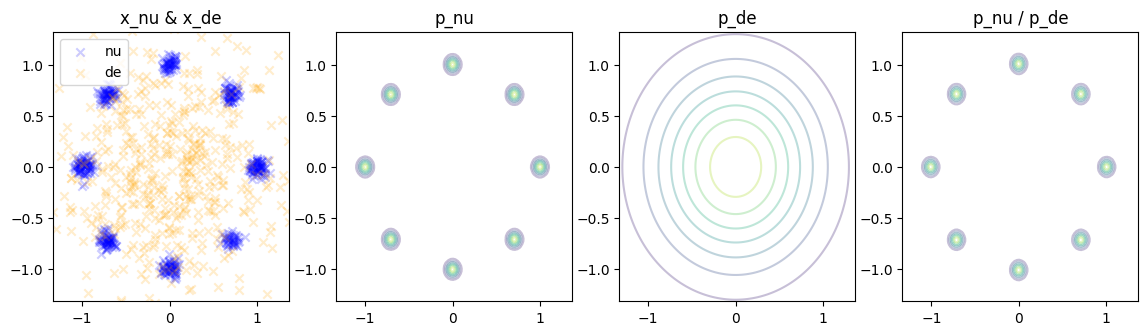

In [193]:
using Distributions
using LinearAlgebra: dot, norm
using MLToolkit: plt, plot_contour!, autoset_lim!, make_two_y_axes_plot
using DensityRatioEstimation
import MLToolkit

include("data.jl")

dist_nu = Ring(8, 1, 5f-2)
dist_de = MvNormal(zeros(Float32, 2), 64f-2)
r(x) = exp.(logpdf(dist_nu, x)) ./ exp.(logpdf(dist_de, x))

n_nu = 500
x_nu = rand(dist_nu, n_nu)
n_de = 500
x_de = rand(dist_de, n_de)

function plotdata!(x_nu, x_de; ax=plt.gca())
    ax.scatter(x_nu[1,:], x_nu[2,:], marker="x", c="blue", label="nu", alpha=0.2)
    ax.scatter(x_de[1,:], x_de[2,:], marker="x", c="orange", label="de", alpha=0.2)
end

plt.figure(figsize=(14, 3.5))

plt.subplot(1, 4, 1)
plotdata!(x_nu, x_de)
autoset_lim!(x_nu)
plt.legend()
plt.title("x_nu & x_de")

plt.subplot(1, 4, 2)
autoset_lim!(x_nu)
plot_dist!(dist_nu)
plt.title("p_nu")

plt.subplot(1, 4, 3)
autoset_lim!(x_nu)
plot_dist!(dist_de)
plt.title("p_de")

plt.subplot(1, 4, 4)
autoset_lim!(x_nu)
plot_contour!(r)
plt.title("p_nu / p_de")

;

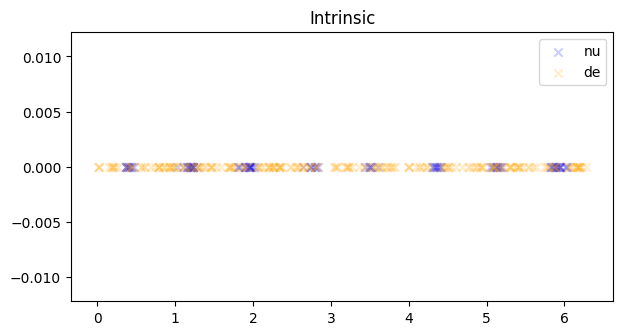

PyObject <matplotlib.legend.Legend object at 0x7f9754d8c0f0>

In [3]:
function f_intrinsic(x)
    base_angle = π / dist_nu.n_clusters
    c1 = dot(x, [cos(base_angle), sin(base_angle)]) / norm(x)
    c2 = dot(x, [-sin(base_angle), cos(base_angle)]) / norm(x)
    a1 = acos(c1)
    a2 = acos(c2)
    if a2 < π / 2
        return a1
    else
        return 2π - a1
    end
end

intrinsic_nu = [f_intrinsic(x_nu[:,i]) for i in 1:size(x_nu, 2)]
intrinsic_nu = reshape(intrinsic_nu, 1, length(intrinsic_nu))
intrinsic_de = [f_intrinsic(x_de[:,i]) for i in 1:size(x_de, 2)]
intrinsic_de = reshape(intrinsic_de, 1, length(intrinsic_de))

function plotintrinsic!(; ax=plt.gca())
    ax.scatter(intrinsic_nu, zeros(length(intrinsic_nu)), marker="x", c="blue", alpha=0.2, label="nu")
    ax.scatter(intrinsic_de, zeros(length(intrinsic_de)), marker="x", c="orange", alpha=0.2, label="de")
end

plt.figure(figsize=(7, 3.5))
plotintrinsic!()
plt.title("Intrinsic")
plt.legend()

In [4]:
σs = [1, 2, 4, 8, 16]

5-element Array{Int64,1}:
  1
  2
  4
  8
 16

┌ Info: Automatically choose σ using the median of pairwise distances: 1.1275527.
└ @ DensityRatioEstimation /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/DensityRatioEstimation/LuSEi/src/moment_matching.jl:41
┌ Info: Automatically choose σ using the median of pairwise distances: 1.1967504.
└ @ DensityRatioEstimation /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/DensityRatioEstimation/LuSEi/src/moment_matching.jl:41



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



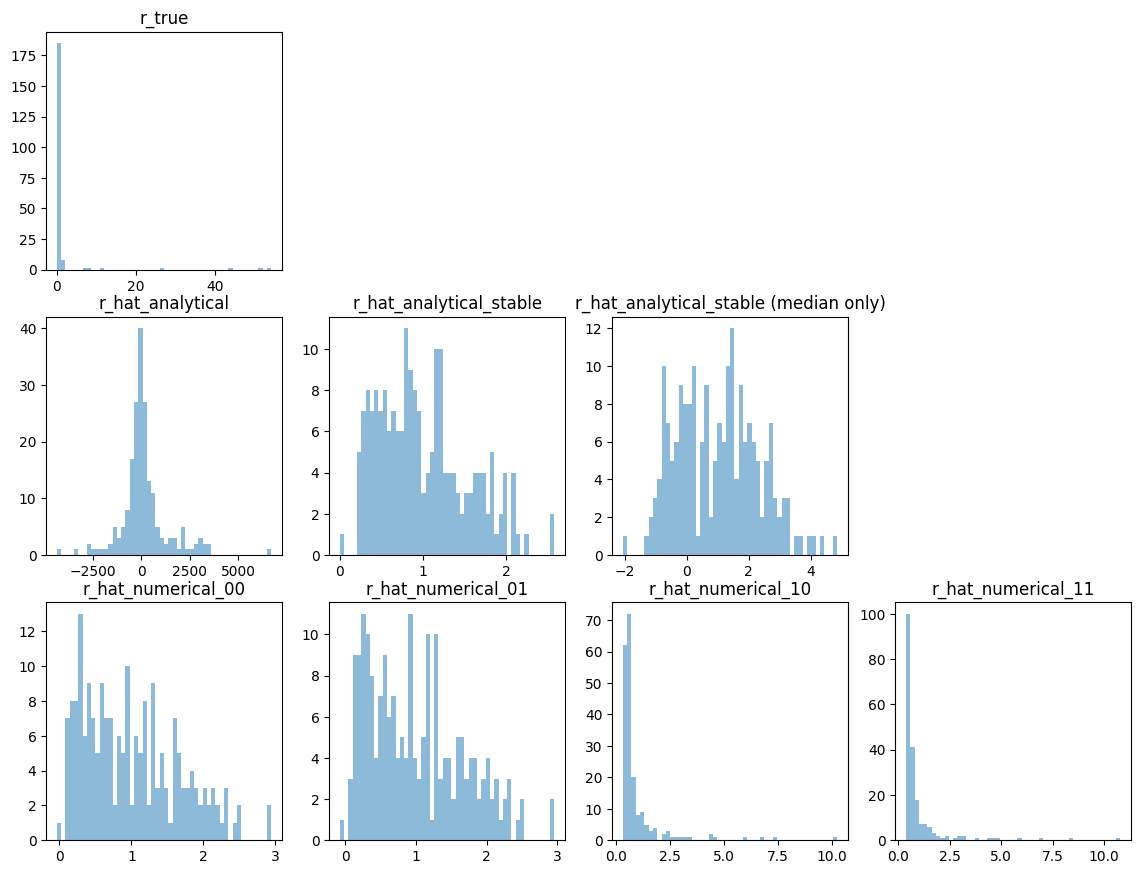

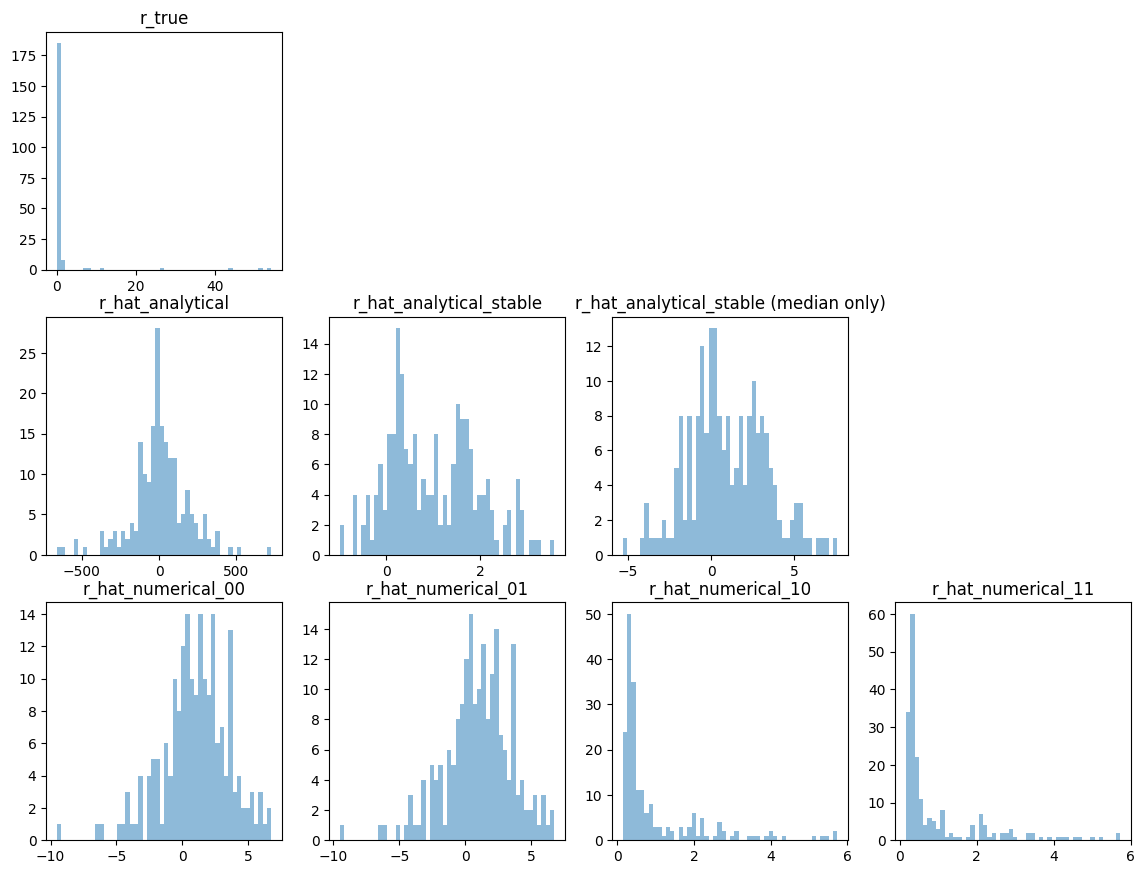

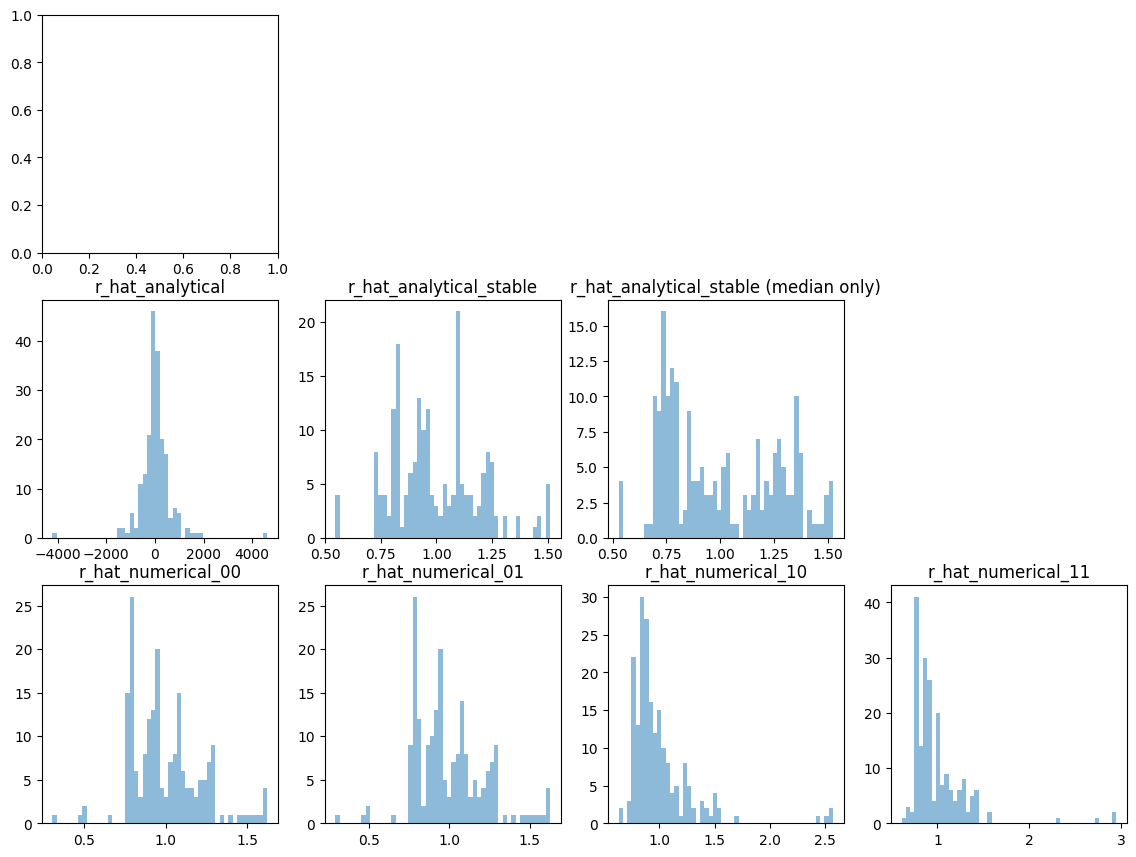

┌ Info: Automatically choose σ using the median of pairwise distances: 1.8897504092842188.
└ @ DensityRatioEstimation /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/DensityRatioEstimation/LuSEi/src/moment_matching.jl:41


In [5]:


function makeplot(x_nu, x_de)
    fig = plt.figure(figsize=(14, 10.5))
    bins = 50

    plt.subplot(3, 4, 1)
    if size(x_de, 1) > 1
        r_true = exp.(logpdf(dist_nu, x_de[1:2,:])) ./ exp.(logpdf(dist_de, x_de[1:2,:]))
        plt.hist(r_true, bins=bins, alpha=0.5)
        plt.title("r_true")
    end

    plt.subplot(3, 4, 5)
    r_hat_analytical = estimate_ratio(MMDAnalytical(ϵ=0), x_de, x_nu; σs=σs)
    plt.hist(r_hat_analytical, bins=bins, alpha=0.5)
    plt.title("r_hat_analytical")

    plt.subplot(3, 4, 6)
    r_hat_analytical_stable = estimate_ratio(MMDAnalytical(), x_de, x_nu; σs=σs)
    plt.hist(r_hat_analytical_stable, bins=bins, alpha=0.5)
    plt.title("r_hat_analytical_stable")

    plt.subplot(3, 4, 7)
    r_hat_analytical_stable = estimate_ratio(MMDAnalytical(), x_de, x_nu)
    plt.hist(r_hat_analytical_stable, bins=bins, alpha=0.5)
    plt.title("r_hat_analytical_stable (median only)")
    
    plt.subplot(3, 4, 9)
    r_hat_numerical_00 = estimate_ratio(MMDNumerical(positivity=false, normalisation=false), x_de, x_nu; σs=σs)
    plt.hist(r_hat_numerical_00, bins=bins, alpha=0.5)
    plt.title("r_hat_numerical_00")

    plt.subplot(3, 4, 10)
    r_hat_numerical_01 = estimate_ratio(MMDNumerical(positivity=false, normalisation=true), x_de, x_nu; σs=σs)
    plt.hist(r_hat_numerical_01, bins=bins, alpha=0.5)
    plt.title("r_hat_numerical_01")

    plt.subplot(3, 4, 11)
    r_hat_numerical_10 = estimate_ratio(MMDNumerical(positivity=true, normalisation=false), x_de, x_nu; σs=σs)
    plt.hist(r_hat_numerical_10, bins=bins, alpha=0.5)
    plt.title("r_hat_numerical_10")

    plt.subplot(3, 4, 12)
    r_hat_numerical_11 = estimate_ratio(MMDNumerical(positivity=true, normalisation=true), x_de, x_nu; σs=σs)
    plt.hist(r_hat_numerical_11, bins=bins, alpha=0.5)
    plt.title("r_hat_numerical_11")

    return fig
end

makeplot(x_nu, x_de)

Dx, Dy = 2, 10

y_nu = vcat(x_nu, 1f-1 * randn(Float32, Dy - Dx, size(x_nu, 2)))
y_de = vcat(x_de, 1f-1 * randn(Float32, Dy - Dx, size(x_de, 2)))

makeplot(y_nu, y_de)

makeplot(intrinsic_nu, intrinsic_de)

;

In [7]:
using Flux
using Random: seed!
using Flux: Tracker
using ProgressMeter: @showprogress

┌ Info: Recompiling stale cache file /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/compiled/v1.1/Flux/QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1184


┌ Info: Recompiling stale cache file /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/compiled/v1.1/Flux/QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1184


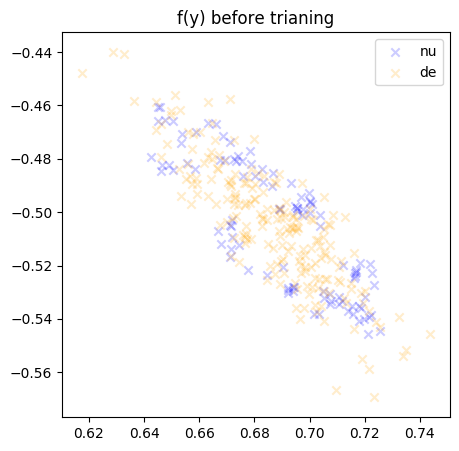

In [6]:
seed!(1)

r_x_de = r(x_de)
r_x_de_ana = estimate_ratio(MMDAnalytical(), x_de, x_nu; σs=σs)
r_x_de_num = estimate_ratio(MMDNumerical(), x_de, x_nu; σs=σs)

r_y_de_ana = estimate_ratio(MMDAnalytical(), y_de, y_nu; σs=σs)
r_y_de_num = estimate_ratio(MMDNumerical(), y_de, y_nu; σs=σs)

r_intrinsic_de_ana = estimate_ratio(MMDAnalytical(), intrinsic_de, intrinsic_nu; σs=σs)
r_intrinsic_de_num = estimate_ratio(MMDNumerical(), intrinsic_de, intrinsic_nu; σs=σs)

Dh = 20
Dz = Dx

f = Chain(Dense(Dy, Dh, sigmoid), Dense(Dh, Dh, sigmoid), Dense(Dh, Dx))

function forward()
    fy_de, fy_nu = f(y_de), f(y_nu)
    r_fy_de_ana = estimate_ratio(MMDAnalytical(), fy_de, fy_nu; σs=σs)
#     loss_f = -mean(r_fy_de_ana)
#     loss_f = -mean((r_fy_de_ana .- 1) .^ 2)
#     loss_f = -(mean((r_fy_de_ana .- 1) .^ 2) + mean(r_fy_de_ana))
    loss_f = mean((r_fy_de_ana .- r_y_de_ana) .^ 2)
    return (
        fy_de=fy_de,
        fy_nu=fy_nu,
        loss_f=loss_f,
    )
end

function eval(fy_de, fy_nu)
    r_fy_de_num = estimate_ratio(MMDNumerical(), fy_de, fy_nu; σs=σs)
    r_fy_de = r(fy_de)
    return (
        D_num=mean((r_y_de_num - r_fy_de_num) .^ 2),
#         D=mean((r_y_de - r_fy_de) .^ 2),
        pd_y_num=mean((r_y_de_num .- 1) .^ 2),
#         pd_y=mean((r_y_de .- 1) .^ 2),
        pd_fy_num=mean((r_fy_de_num .- 1) .^ 2),
        pd_fy=mean((r_fy_de .- 1) .^ 2),
    )
end

iter0 = 0

opt_f = ADAM(1f-3)
ps_f = Flux.params(f)

trace = Dict(
    :iter_tr => [],
    :loss_f => [],
    :iter_eval => [],
    :D_num => [],
#     :D => [],
    :pd_y_num => [],
#     :pd_y => [],
    :pd_fy_num => [],
    :pd_fy => [],
)

fy_nu_0, fy_de_0 = f(y_nu) |> Flux.data, f(y_de) |> Flux.data

plt.figure(figsize=(5, 5))
plotdata!(fy_nu_0, fy_de_0)
plt.legend()
plt.title("f(y) before trianing")

;

In [22]:
n_iters = 10_000
@showprogress for iter in (iter0+1):(iter0+n_iters)
    res = forward()
    loss_f = res[:loss_f]
    gs_f = Tracker.gradient(() -> loss_f, ps_f)
    Tracker.update!(opt_f, ps_f, gs_f)
    push!(trace[:iter_tr], iter)
    push!(trace[:loss_f], loss_f |> Flux.data)
    if iter % 20 == 0
        res = eval(res.fy_de |> Flux.data, res.fy_nu |> Flux.data)
        push!(trace[:iter_eval], iter)
        for k in keys(res)
            push!(trace[k], res[k])
        end
    end
end
iter0 += n_iters

;

Progress: 100%|█████████████████████████████████████████| Time: 0:10:25


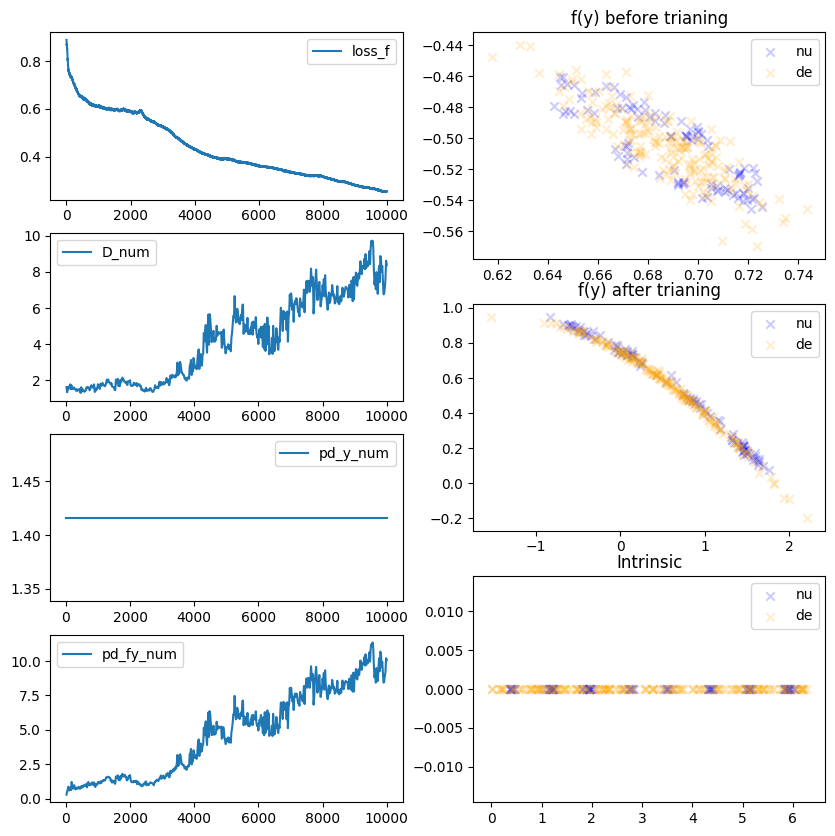

In [23]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 2, 1)
plt.plot(trace[:iter_tr], trace[:loss_f], label="loss_f")
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(trace[:iter_eval], trace[:D_num], label="D_num")
# plt.plot(trace[:iter_eval], trace[:D], label="D")
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(trace[:iter_eval], trace[:pd_y_num], label="pd_y_num")
# plt.plot(trace[:iter_eval], trace[:pd_y], label="pd_y")
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(trace[:iter_eval], trace[:pd_fy_num], label="pd_fy_num")
# plt.plot(trace[:iter_eval], trace[:pd_fy], label="pd_fy")
plt.legend()

plt.subplot(3, 2, 2)
plotdata!(fy_nu_0, fy_de_0)
plt.legend()
plt.title("f(y) before trianing")

plt.subplot(3, 2, 4)
plotdata!(f(y_nu) |> Flux.data, f(y_de) |> Flux.data)
plt.legend()
plt.title("f(y) after trianing")

plt.subplot(3, 2, 6)
plotintrinsic!()
plt.legend()
plt.title("Intrinsic")

;